In [1]:
import pickle
import os

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import collections
import pandas as pd
import seaborn as sns
import random

from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [2]:
#filename = 'all_data'
filename = 'mrpc25_cola25_rte25_sst15'
with open('/home/ilharco/Desktop/data/'+filename, 'rb') as f:
    data = pickle.load(f)

tasks = ['mrpc', 'rte', 'cola', 'sst']

batch_nums = {
    "sst": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4310, 4410, 4510, 4610, 4710, 4810, 4910, 5010, 5110, 5210, 5310, 5410, 5510, 5610, 5710, 5810, 5910, 6010, 6110, 6210, 6310, 6410, 6510, 6610, 6710, 6810, 6910, 7010, 7110, 7210, 7310, 7410, 7510, 7610, 7710, 7810, 7910, 8010, 8110, 8210, 8310, 8410, 8520, 8620, 8720, 8820, 8920, 9020, 9120, 9220, 9320, 9420, 9520, 9620, 9720, 9820, 9920, 10020, 10120, 10220, 10320, 10420, 10520, 10620, 10720, 10820, 10920, 11020, 11120, 11220, 11320, 11420, 11520, 11620, 11720, 11820, 11920, 12020, 12120, 12220, 12320, 12420, 12520, 12620],
    "mrpc":[0,23,46,69,92,115,138,161,184,207,230,253,276,299,322,345,368,391,414,437,460,483,506,529,552,575,598,621,644,667],
    "cola":[0,53,106,159,212,265,318,371,424,477,530,588,641,694,747,800,853,906,959,1012,1065,1123,1176,1229,1282,1335,1388,1441,1494,1547,1600],
    "rte":[0,21,36,51,66,81,96,111,126,141,156,171,186,201,216,231,246,261,276,291,306,327,342,357,372,387,402,417,432,447,462],
}

iterations = {task: batch_nums[task][-1] for task in tasks}

intervals = {'sst': 100, 'mrpc': 23, 'cola': 53, 'rte': 15}

ylims = {
    'cola': (-0.1, 0.8),
    'mrpc': (0.2, 1.0),
    'sst': (0.4, 1.0),
    'rte': (0.0, 1.0)
}

perf = {'cola': 'mcc', 'mrpc': 'acc_and_f1', 'sst': 'acc', 'rte': 'acc' }
perf_pretty = {'cola': 'MCC', 'mrpc': 'Acc./F1', 'sst': 'Accuracy', 'rte': 'Accuracy'}
names = {'cola': 'CoLA', 'mrpc': 'MRPC', 'sst': 'SST', 'rte': 'RTE'}

init_seeds = {task: np.array(sorted(list(data[task].keys()))) for task in tasks}
data_seeds = {
    task: np.array(sorted(list(data[task][init_seeds[task][0]].keys()))) for task in tasks}


In [12]:
with open('/home/ilharco/Desktop/data/early_stopping_results', 'rb') as f:
    early_stopping_data = pickle.load(f)

In [123]:

def find_baseline(experiments):
    for experiment in experiments:
        if experiment[2]['num_stop'] == 0:
            return experiment

def get_rel_err(result, budget, baseline):
    perf_err = 1-result[0]
    baseline_err = 1-baseline[0]
    rel_err_imp = (baseline_err-perf_err)/baseline_err
    return rel_err_imp 
    
dataset_to_plot_data = {}
for dataset in early_stopping_data:
    if dataset == "settings":
        continue
    dataset_to_plot_data[dataset] = {}
    for budget in early_stopping_data[dataset]:
        baseline = find_baseline(early_stopping_data[dataset][budget])
        best_result = early_stopping_data[dataset][budget][-1]
        dataset_to_plot_data[dataset][budget] = get_rel_err(best_result, budget, baseline)

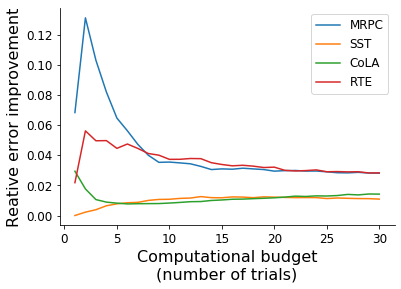

In [134]:
plt.figure()
fontsize=16
for dataset, budgets_to_improvements in dataset_to_plot_data.items():
    xs = sorted(list(budgets_to_improvements.keys()))
    ys = [budgets_to_improvements[x] for x in xs]
    plt.plot(xs, ys, label=names[dataset])

plt.xlabel('Computational budget\n(number of trials)', fontsize=fontsize)
plt.ylabel('Reative error improvement', fontsize=fontsize)
plt.legend(fontsize=12)
ax = plt.gca()
ax.tick_params(labelsize=12)

filename = '/home/ilharco/Desktop/data/relative_improvement'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')


In [13]:
top_k = 1
def single_best(dataset_to_budget_to_results):
    dataset_to_plot_data = {}
    for dataset in dataset_to_budget_to_results:
        if dataset == "settings":
            continue
        dataset_to_plot_data[dataset] = {}
        for budget in dataset_to_budget_to_results[dataset]:

            baseline = find_baseline(dataset_to_budget_to_results[dataset][budget])
            
            for k in range(top_k):
                kth_best_result = dataset_to_budget_to_results[dataset][budget][-(k + 1)]
                result = get_one_result(kth_best_result, budget, baseline)
            if k > 1:
                print("")
            else:
                dataset_to_plot_data[dataset][budget] = result
    return dataset_to_plot_data

def find_baseline(experiments):
    for experiment in experiments:
        if experiment[2]['num_stop'] == 0:
            return experiment
        
def get_one_result(result, budget, baseline):
    perf = result[0]
    improve = result[0] - baseline[0]
    num_started = result[2]['num_exp']
    num_fully_train = result[2]['num_exp'] - result[2]['num_stop']
    percent_stop = result[2]['num_stop'] * 1.0 / result[2]['num_exp']
    percent_data = result[2]['num_evals'] * 1.0 / result[2]['num_evals_per_exp']

    return {'performance': perf, 'improvement': improve, 'num_started': num_started,
            'num_fully_train': num_fully_train, 'percent_stop': percent_stop, 'percent_data': percent_data}

def format_data(unformatted_data):
    data = {}
    for dataset in unformatted_data:
        data[dataset] = {}
        data[dataset]['num_started'] = []
        data[dataset]['num_fully_train'] = []
        data[dataset]['percent_data'] = []
        for budget in unformatted_data[dataset]:
            data[dataset]['num_started'].append(unformatted_data[dataset][budget]['num_started'])
            data[dataset]['num_fully_train'].append(unformatted_data[dataset][budget]['num_fully_train'])
            data[dataset]['percent_data'].append(unformatted_data[dataset][budget]['percent_data'])
    return data

formatted_es_data = format_data(single_best(early_stopping_data))

In [14]:
formatted_es_data.keys()

dict_keys(['mrpc', 'sst', 'cola', 'rte'])

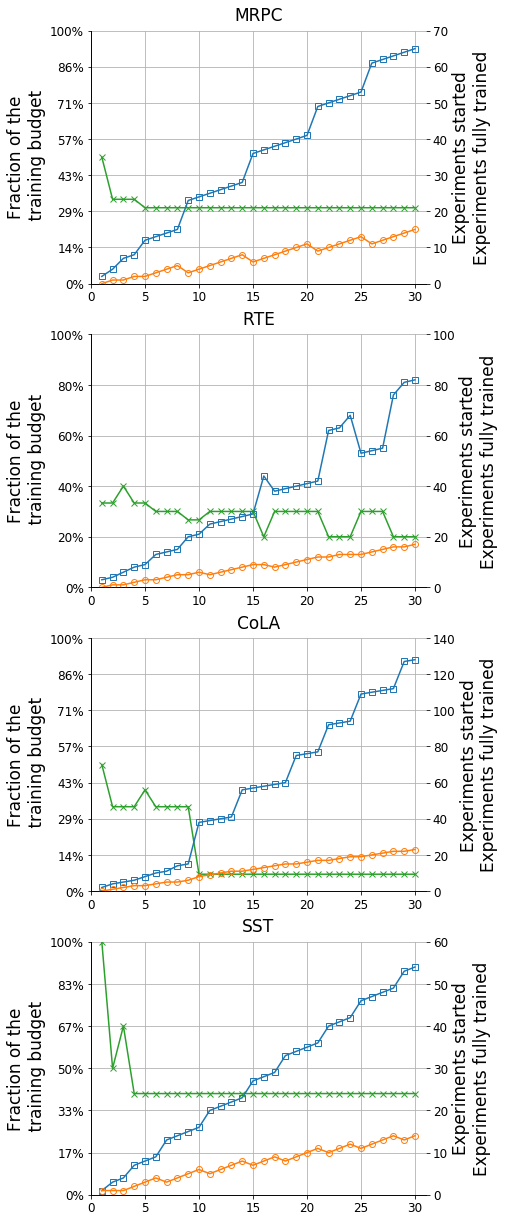

In [109]:
# Matrix plots
fontsize=17
f, axs = plt.subplots(len(tasks), 1, figsize=(4*1.5, 11*1.5))
plt.subplots_adjust(bottom=-0.1)
for idx,(task, ax2) in enumerate(zip(tasks, axs)):
    line3, = ax2.plot(range(1,31), formatted_es_data[task]['percent_data'], marker='x', fillstyle='none', color='#2ca02c')
    ax1 = ax2.twinx()
    line1, = ax1.plot(range(1,31), formatted_es_data[task]['num_started'], marker='s', fillstyle='none', color='#1f77b4')
    line2, = ax1.plot(range(1,31), formatted_es_data[task]['num_fully_train'], marker='o', fillstyle='none', color='#ff7f0e')
    ax2_y_ticks = np.linspace(0, 1, len(ax1.get_yticks())-1).tolist()
    ax2_y_ticks = [-ax2_y_ticks[1]] + ax2_y_ticks
    ax2.set_yticks(ax2_y_ticks)

    # to get the ylim
    lower_proportion = ax1.get_ylim()[0] / ax1.get_yticks()[0]
    ax2_lower_y_lim = ax2_y_ticks[0]*lower_proportion

    upper_dist = ax1.get_yticks()[-1] - ax1.get_yticks()[-2]
    upper_proportion = (ax1.get_ylim()[1] - ax1.get_yticks()[-2]) / upper_dist
    ax2_step_dist = ax2_y_ticks[-1] - ax2_y_ticks[-2]
    ax2_upper_y_lim = ax2.get_yticks()[-2] + ax2_step_dist * upper_proportion

    ax2.set_ylim((ax2_lower_y_lim, ax2_upper_y_lim))

    ax2_ylabels = [str(round(percent * 100)) + "%" for percent in ax2_y_ticks]
    #ax2_ylabels = ax2_ylabels[1,len(ax2_ylabels)]]
    ax2.set_yticklabels(ax2_ylabels)

    upper_ylim_1 = True
    if upper_ylim_1:
#         ax1.set_ylim((ax1.get_ylim()[0], ax1.get_yticks()[-1]))
#         ax2.set_ylim((ax2.get_ylim()[0], ax2.get_yticks()[-1]))
        ax1.set_ylim((0, ax1.get_yticks()[-1]))
        ax2.set_ylim((0, ax2.get_yticks()[-1]))
        
    if idx == len(tasks)-1: ax1.set_xlabel('Budget sufficient to train X models on all data', fontsize=fontsize)
    ax1.set_ylabel('Experiments started\nExperiments fully trained', fontsize=fontsize)
    ax2.set_ylabel('Fraction of the\n training budget', fontsize=fontsize)
    ax1.set_title(names[task], fontsize=fontsize, pad=10)    
    ax2.grid(None)
    ax1.set_xlim(0,31)
    ax1.tick_params(labelsize=12); ax2.tick_params(labelsize=12)
    
#     if idx ==1:
#         ax1.legend((line1,line2), ("", ""), loc=(1.15,0.4), fontsize=12)
#         ax2.legend((line3,), ("",), loc=(1.3,0.4), fontsize=12)
#     if idx == 0:
#         ax1.legend((line1,line2), ("exp. started (s)", "exp. fully trained (f)"), loc=(0.48,0.33), fontsize=12)
#         ax2.legend((line3,), ("fraction of the\ntraining budget (k)",), loc=2, fontsize=12)
#         ax2.legend((line1, line2, line3), ("Exp. started (s)", "Exp. trained fully (f)",
#                                            "Fracion of training budget (k)"), loc=2, fontsize=12.5)
filename = '/home/ilharco/Desktop/data/optimal_early_stopping'
# plt.ylabel('Weight initialization random seeds', fontsize=fontsize)

plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')
    

In [3]:
performances = {}
intervals = [1,10,-1]
for task in data.keys():
    performances[task] = {i: {} for i in intervals}
    for init_seed in init_seeds[task]:
        for data_seed in data_seeds[task]:
            d = data[task][init_seed][data_seed][perf[task]]['during']
            d = [e[1] for e in d if e[0] in batch_nums[task]]
            for i in intervals:
                if i == -1: performances[task][i][(init_seed, data_seed)] = d[-1]
                else: performances[task][i][(init_seed, data_seed)] = max(max(d[::i]), d[-1])

In [4]:
def get_values(task, init_seed=None, data_seed=None, eval_every=1):
    d = performances[task][eval_every]
    if init_seed is not None and data_seed is not None:
        return [d[(init_seed,data_seed)]]
    if init_seed is not None:
        return [d[(init_seed, data_seed)] for data_seed in data_seeds[task]]
    if data_seed is not None:
        return [d[(init_seed, data_seed)] for init_seed in init_seeds[task]]
    return list(d.values())

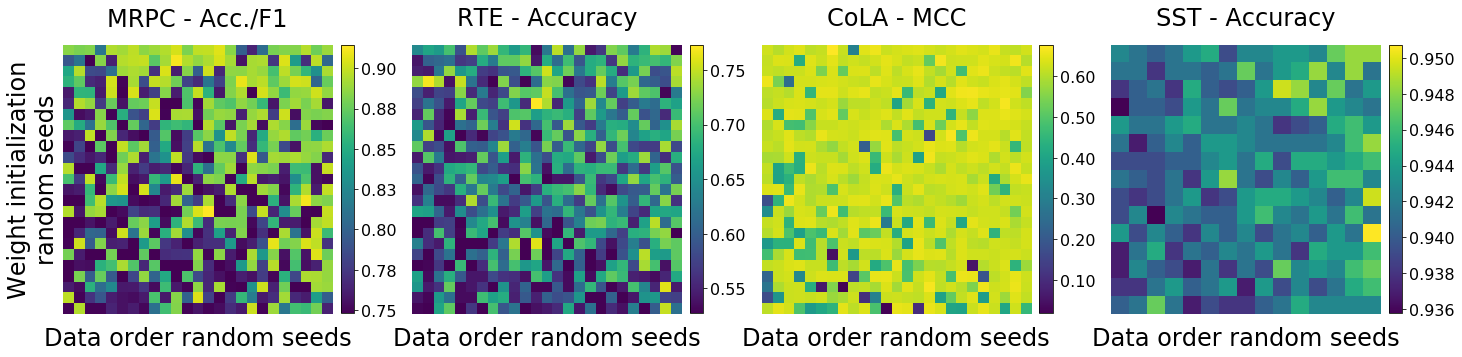

In [6]:
# Matrix plots
fontsize=20
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 3*1.5))
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    matrix = np.zeros((len(init_seeds[task]), len(data_seeds[task])))
    sorted_init_seeds = sorted(init_seeds[task], key=lambda x: np.mean(get_values(task, init_seed=x, eval_every=1)))
    sorted_data_seeds = sorted(data_seeds[task], key=lambda x: np.mean(get_values(task, data_seed=x, eval_every=1)))

    for i, init_seed in enumerate(sorted_init_seeds[::-1]):
        for j, data_seed in enumerate(sorted_data_seeds):
            matrix[i][j] = get_values(task, init_seed, data_seed, True)[0]
    
    ax = fig.add_subplot(1, len(tasks), idx+1)
    im = ax.matshow(matrix)#, vmin=mean-2*std,vmax=mean+2*std)
    plt.xlabel('Data order random seeds', fontsize=fontsize, labelpad=12)
    if idx == 0: plt.ylabel('Weight initialization\nrandom seeds', fontsize=fontsize)
    cbar = plt.colorbar(im,fraction=0.046, pad=0.03, format='%.3f' if idx==3 else '%.2f')
    cbar.ax.tick_params(labelsize=16)
    for n in ['right', 'top', 'bottom', 'left']: ax.spines[n].set_visible(False)
    plt.xticks([], []); plt.yticks([], [])

#     plt.axis('off')
    plt.title(names[task]+' - ' + perf_pretty[task], fontsize=fontsize)
filename = '/home/ilharco/Desktop/data/matrix'
# plt.ylabel('Weight initialization random seeds', fontsize=fontsize)
    
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')
    

In [7]:
def _cdf_with_replacement(i,n,N): return (i/N)**n

def _compute_variance(N, cur_data, expected_max_cond_n, pdfs):
    variance_of_max_cond_n = []
    for n in range(N):
        cur_var = 0
        for i in range(N): cur_var += (cur_data[i] - expected_max_cond_n[n])**2 * pdfs[n][i]
        cur_var = np.sqrt(cur_var)
        variance_of_max_cond_n.append(cur_var)
    return variance_of_max_cond_n

def samplemax(validation_performance):
    validation_performance = list(validation_performance)
    validation_performance.sort()
    N = len(validation_performance)
    pdfs = []
    for n in range(1,N+1):
        F_Y_of_y = []
        for i in range(1,N+1): F_Y_of_y.append(_cdf_with_replacement(i,n,N))
        f_Y_of_y = []
        cur_cdf_val = 0
        for i in range(len(F_Y_of_y)):
            f_Y_of_y.append(F_Y_of_y[i] - cur_cdf_val)
            cur_cdf_val = F_Y_of_y[i]
        pdfs.append(f_Y_of_y)
    expected_max_cond_n = []
    for n in range(N):
        cur_expected = 0
        for i in range(N):
            cur_expected += validation_performance[i] * pdfs[n][i]
        expected_max_cond_n.append(cur_expected)
    var_of_max_cond_n = _compute_variance(N, validation_performance, expected_max_cond_n, pdfs)
    return {"mean":expected_max_cond_n, "var":var_of_max_cond_n, "max": np.max(validation_performance),
            "min":np.min(validation_performance)}

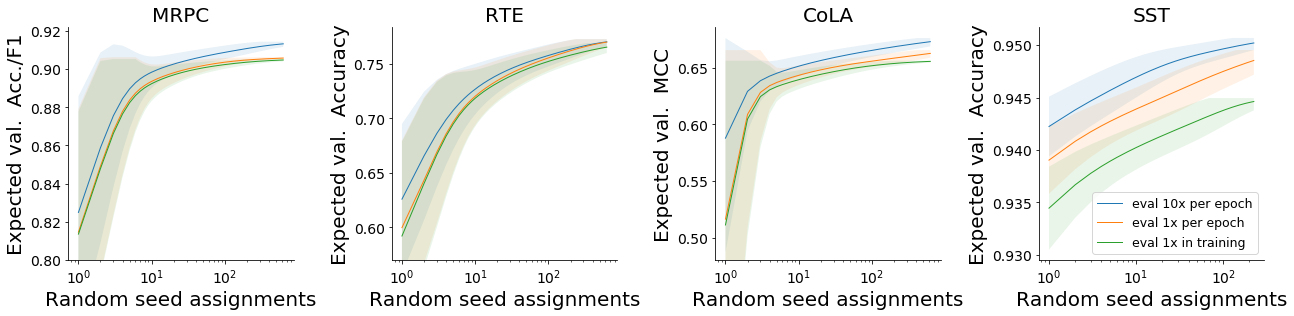

In [123]:
# Expected validation curves
fontsize=20
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 3*1.5))
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    ax.set_title(names[task], fontsize=fontsize)
    ax.set_ylabel("Expected val.  " + perf_pretty[task], fontsize=fontsize)
    ax.set_xlabel("Random seed assignments",fontsize=fontsize)
    ax.set_xscale('log')

    left, right = 1000, -1000
    for eval_every in intervals:
        vals = get_values(task, eval_every=eval_every)
        smax = samplemax(vals)
        means = smax['mean']; vars = smax['var']; max_acc = smax['max']; min_acc = smax['min']
        x_axis = [i+1 for i in range(len(means))]
        minus_vars = [x - y if (x - y) >= min_acc else min_acc for x,y in zip(means, vars)]
        plus_vars = [x + y if (x + y) <= max_acc else max_acc for x,y in zip(means, vars)]
        ax.fill_between(x_axis, minus_vars, plus_vars, alpha=0.1)
        if eval_every == 1: label = 'eval 10x per epoch'
        elif eval_every == 10: label = 'eval 1x per epoch'
        else: label = 'eval 1x in training'
        ax.plot(x_axis, means, linestyle="-", linewidth=1, label=label)
        ax.tick_params(labelsize=14)
        c_left, c_right = ax.get_xlim()
        left = min(left, c_left); right = max(right, c_right)
        if task == 'cola': ax.set_ylim(.48, ax.get_ylim()[1])
        if task == 'mrpc': ax.set_ylim(.8, ax.get_ylim()[1])
        if task == 'rte': ax.set_ylim(.57, ax.get_ylim()[1])
    ax.set_xlim((left, right))
#     if idx == 3: ax.set_ylim(0.93, .952)
    plt.locator_params(axis='y', nbins=6)
    plt.tight_layout()
plt.legend(loc='lower right', fontsize=12.5)
filename = '/home/ilharco/Desktop/data/expected_validation'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

In [16]:
for task in ['mrpc', 'rte', 'cola', 'sst']:
    sorted_init_seeds = sorted(init_seeds[task], key=lambda x: np.mean(get_values(task, init_seed=x)))
    sorted_data_seeds = sorted(data_seeds[task], key=lambda x: np.mean(get_values(task, data_seed=x)))

    all_stats = []
    best = get_values(task, init_seed=sorted_init_seeds[-1])
    worse = get_values(task, init_seed=sorted_init_seeds[0])
    ks, ks_p = scipy.stats.ks_2samp(best, worse)
    f, f_p = scipy.stats.f_oneway(best, worse)

    print(task + (', init (%d and %d):' % (sorted_init_seeds[-1], sorted_init_seeds[0])))
    #print('  KS: %.2f, p-value: %.2g' % (ks, ks_p))
    print('  ANOVA: %.2f, p-value: %.1e' % (f, f_p))

    all_stats = []
    best = get_values(task, data_seed=sorted_data_seeds[-1])
    worse = get_values(task, data_seed=sorted_data_seeds[0])
    ks, ks_p = scipy.stats.ks_2samp(best, worse)
    f, f_p = scipy.stats.f_oneway(best, worse)

    print(task + (', data (%d and %d):' % (sorted_data_seeds[-1], sorted_data_seeds[0])))
    #print('  KS: %.2f, p-value: %.2g' % (ks, ks_p))
    print('  ANOVA: %.2f, p-value: %.1e' % (f, f_p))

    print('='*50)

mrpc, init (20 and 16):
  ANOVA: 29.26, p-value: 2.0e-06
mrpc, data (24 and 21):
  ANOVA: 7.57, p-value: 8.3e-03
rte, init (12 and 19):
  ANOVA: 15.34, p-value: 2.8e-04
rte, data (22 and 13):
  ANOVA: 9.64, p-value: 3.2e-03
cola, init (12 and 11):
  ANOVA: 7.95, p-value: 7.0e-03
cola, data (6 and 22):
  ANOVA: 7.03, p-value: 1.1e-02
sst, init (4 and 9):
  ANOVA: 5.03, p-value: 3.3e-02
sst, data (6 and 14):
  ANOVA: 27.85, p-value: 1.3e-05


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


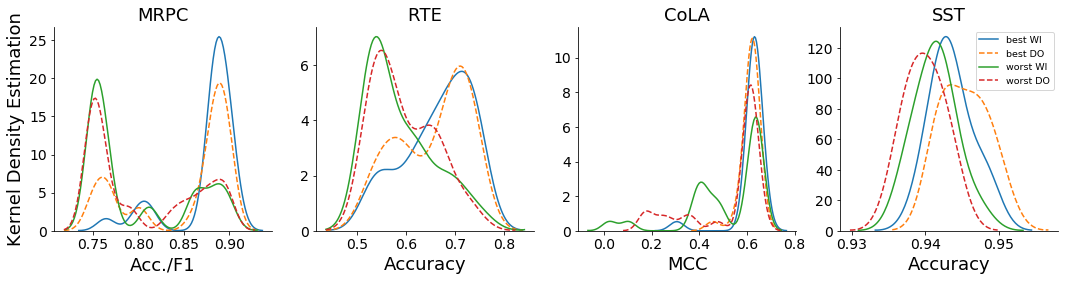

In [10]:
bws = {'cola': 0.03, 'rte': 0.03, 'mrpc': 0.01, 'sst': 0.002}
fontsize=18
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
# plt.subplots_adjust(wspace=.3)
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    sorted_init_seeds = sorted(init_seeds[task], key=lambda x: np.mean(get_values(task, init_seed=x)))
    sorted_data_seeds = sorted(data_seeds[task], key=lambda x: np.mean(get_values(task, data_seed=x)))

    k = 1
    bw = bws[task]
    for init_seed in sorted_init_seeds[-k:]:
        sns.kdeplot(get_values(task, init_seed=init_seed), label='best WI', bw=bw, ax=ax)
    for data_seed in sorted_data_seeds[-k:]:
        sns.kdeplot(get_values(task, data_seed=data_seed), label='best DO', bw=bw, linestyle='dashed', ax=ax)
    for init_seed in sorted_init_seeds[:k]:
        sns.kdeplot(get_values(task, init_seed=init_seed), label='worst WI', bw=bw, ax=ax)
    for data_seed in sorted_data_seeds[:k]:
        sns.kdeplot(get_values(task, data_seed=data_seed), label='worst DO', bw=bw, linestyle='dashed', ax=ax)
    
    ax.set_title(names[task], fontsize=fontsize)
    if idx ==0: ax.set_ylabel("Kernel Density Estimation", fontsize=fontsize)
    ax.set_xlabel(perf_pretty[task],fontsize=fontsize)
    ax.tick_params(labelsize=14)
        
    plt.legend(fontsize=9.5)
    if idx != 3: ax.get_legend().remove()
filename = '/home/ilharco/Desktop/data/best_and_worst'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

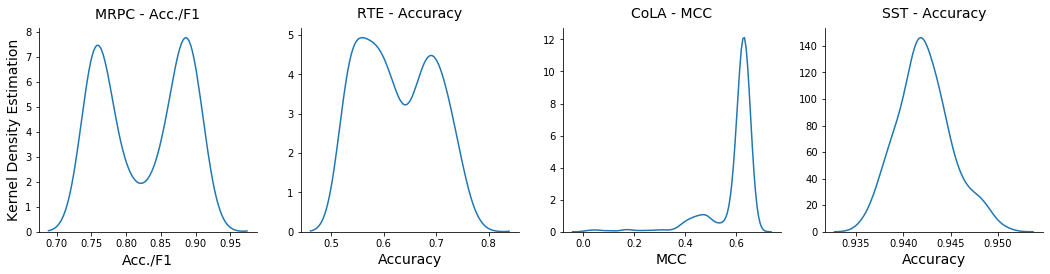

In [352]:
bws = {'cola': 0.02, 'rte': 0.022, 'mrpc': 0.02, 'sst': 0.001}
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    #sns.kdeplot(get_values(task, eval_every=-1), label='final', bw=bws[task], ax=ax)
#     sns.kdeplot(get_values(task, eval_every=1), label='best over training', bw=bws[task], ax=ax)
    sns.kdeplot(get_values(task, eval_every=1), bw=bws[task], ax=ax)
#     sns.distplot(get_values(task), ax=ax, bins=20)
    ax.set_title(names[task] + ' - ' + perf_pretty[task], pad=10, fontsize=14)
    if idx == 0: ax.set_ylabel('Kernel Density Estimation', fontsize=14)
    ax.set_xlabel(perf_pretty[task], fontsize=14)
filename = '/home/ilharco/Desktop/data/kde_best'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

Task mrpc, std: 0.0608, init_std: 0.0575, data_std: 0.0594
Task rte, std: 0.0689, init_std: 0.0659, data_std: 0.0668
Task cola, std: 0.1009, init_std: 0.0902, data_std: 0.0946
Task sst, std: 0.0028, init_std: 0.0028, data_std: 0.0024


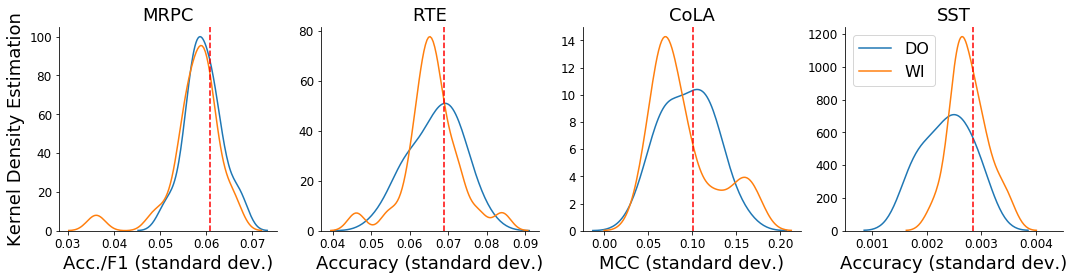

In [48]:
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
fontsize=18
for idx, (task, ax) in enumerate(zip(tasks, axs)):
    init_variances, data_variances = [], []
    for init_seed in init_seeds[task]:
        init_variances.append(np.std(get_values(task, init_seed=init_seed)))
    for data_seed in data_seeds[task]:
        data_variances.append(np.std(get_values(task, data_seed=data_seed)))
    sns.distplot(data_variances, bins=20, hist=False, label='DO', kde_kws={'clip': (0.0, 1.0)}, ax=ax)
    sns.distplot(init_variances, bins=20, hist=False, label='WI', kde_kws={'clip': (0.0, 1.0)}, ax=ax)
    ax.set_title(names[task], fontsize=fontsize)
    if idx == 0: ax.set_ylabel("Kernel Density Estimation", fontsize=fontsize)
    ax.set_xlabel("%s (standard dev.)" % perf_pretty[task],fontsize=fontsize)
    if idx == 3: ax.set_xlim(0.0005, 0.0045)
    std = np.std(get_values(task))
    print('Task %s, std: %.4f, init_std: %.4f, data_std: %.4f' % (task, std, np.mean(init_variances), np.mean(data_variances)))
    ax.axvline(x=std, color='red', linestyle='dashed')
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=16)
    if idx != 3: ax.get_legend().remove()
filename = '/home/ilharco/Desktop/data/std_kde'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

Task mrpc, mean: 0.8250, init_mean: 0.8250, data_mean: 0.8250
Task rte, mean: 0.6260, init_mean: 0.6260, data_mean: 0.6260
Task cola, mean: 0.5877, init_mean: 0.5877, data_mean: 0.5877
Task sst, mean: 0.9422, init_mean: 0.9422, data_mean: 0.9422


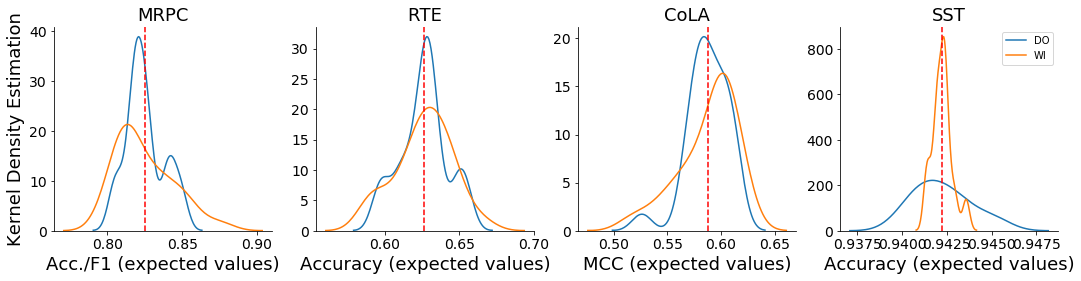

In [28]:
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
fontsize=18
for idx, (task, ax) in enumerate(zip(tasks, axs)):
    init_means, data_means = [], []
    for init_seed in init_seeds[task]:
        init_means.append(np.mean(get_values(task, init_seed=init_seed)))
    for data_seed in data_seeds[task]:
        data_means.append(np.mean(get_values(task, data_seed=data_seed)))
    sns.distplot(data_means, bins=20, hist=False, label='DO', kde_kws={'clip': (0.0, 1.0)}, ax=ax)
    sns.distplot(init_means, bins=20, hist=False, label='WI', kde_kws={'clip': (0.0, 1.0)}, ax=ax)
    ax.set_title(names[task], fontsize=fontsize)
    if idx == 0: ax.set_ylabel("Kernel Density Estimation", fontsize=fontsize)
    ax.set_xlabel("%s (expected values)" % perf_pretty[task],fontsize=fontsize)
#     if idx == 3: ax.set_xlim(0.0005, 0.0045)
    mean = np.mean(get_values(task))
    print('Task %s, mean: %.4f, init_mean: %.4f, data_mean: %.4f' % (task, mean, np.mean(init_means), np.mean(data_means)))
    ax.axvline(x=mean, color='red', linestyle='dashed')
    ax.tick_params(labelsize=14)
        
    if idx != 3: ax.get_legend().remove()
filename = '/home/ilharco/Desktop/data/mean_kde'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

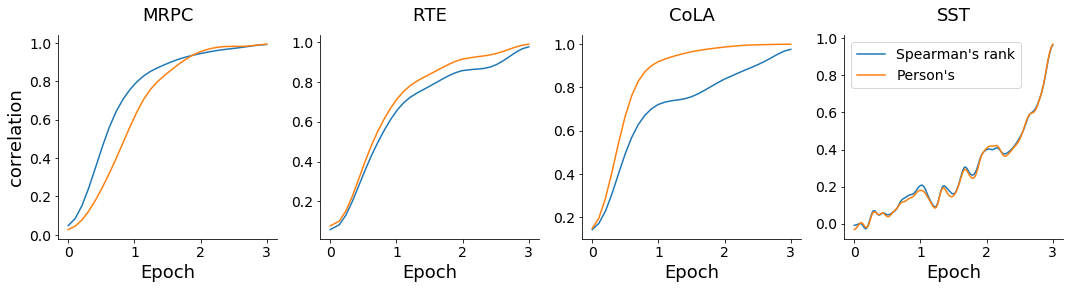

In [50]:
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
# plt.subplots_adjust(wspace=-.1)
fontsize=18
for idx, (task, ax) in enumerate(zip(tasks, axs)):        
    batches = batch_nums[task]
    data_per_batch = collections.defaultdict(list)

    for init_seed in init_seeds[task]:
        for data_seed in data_seeds[task]:
            for [b, v] in data[task][init_seed][data_seed][perf[task]]['during']:
                data_per_batch[b].append(v)

    xs, spearmans, pearsons = [], [], []
    last_batch = batches[-1]
    b2_vals = data_per_batch[last_batch]
    for idx1, b1 in enumerate(batches):
        b1_vals = data_per_batch[b1]
        xs.append(3*b1/last_batch)
        spearmans.append(scipy.stats.spearmanr(b1_vals, b2_vals)[0])
        pearsons.append(scipy.stats.pearsonr(b1_vals, b2_vals)[0])

    sigma = 2
    ax.plot(xs, gaussian_filter1d(spearmans, sigma=sigma), label="Spearman's rank")
    ax.plot(xs, gaussian_filter1d(pearsons, sigma=sigma), label="Person's")
    if idx == 0: ax.set_ylabel("correlation",fontsize=fontsize)
    ax.set_xlabel("Epoch", fontsize=fontsize)
    ax.set_title(names[task], pad=14, fontsize=fontsize)
    ax.tick_params(labelsize=14)
plt.legend(fontsize=14)
filename = '/home/ilharco/Desktop/data/correlation_' + mode
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

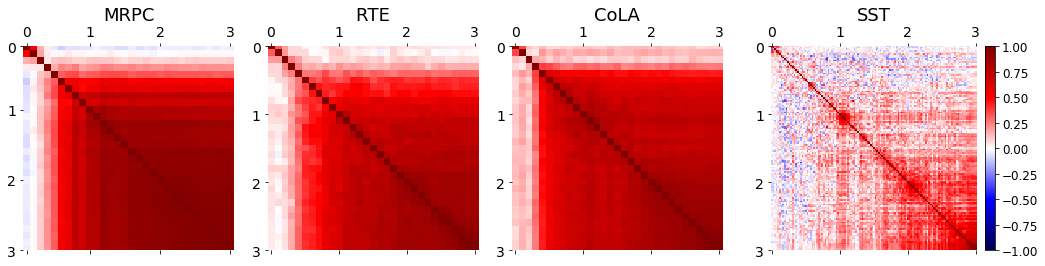

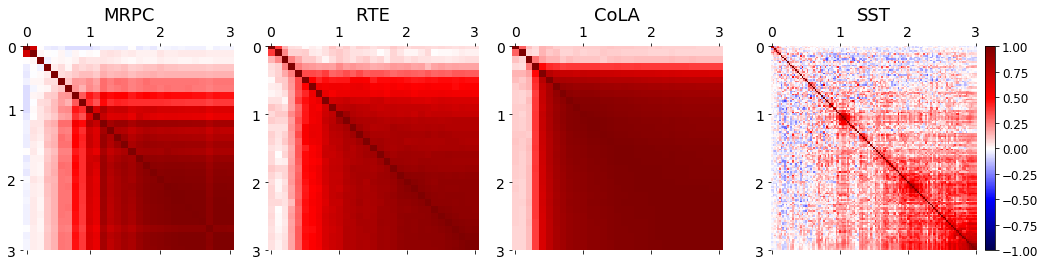

In [85]:
for mode in ['spearman', 'pearson']:
    f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
    pretty_mode ="Spearman's rank" if mode == 'spearman' else 'Pearson'
#     f.suptitle('%s correlation' % pretty_mode, fontsize=17, y=1.1)
    plt.subplots_adjust(wspace=-.1)
    for idx, (task, ax) in enumerate(zip(tasks, axs)):
        batches = batch_nums[task]
        data_per_batch = collections.defaultdict(list)

        for init_seed in init_seeds[task]:
            for data_seed in data_seeds[task]:
                for [b, v] in data[task][init_seed][data_seed][perf[task]]['during']:
                    data_per_batch[b].append(v)

        m = np.zeros((len(batches), len(batches)))
        for idx1, b1 in enumerate(batches):
            b1_vals = data_per_batch[b1]
            for idx2, b2 in enumerate(batches):
                b2_vals = data_per_batch[b2]
                fn = scipy.stats.spearmanr if mode == 'spearman' else scipy.stats.pearsonr
                m[idx1][idx2] = fn(b1_vals, b2_vals)[0]

        im = ax.matshow(m, vmin=-1.0, vmax=1.0, cmap='seismic')
        if idx == 3:
            cbar = plt.colorbar(im,fraction=0.046, pad=0.03, ax=ax)#, format='%.3f' if idx==3 else '%.2f')
            cbar.ax.tick_params(labelsize=12)
    
        for n in ['right', 'top', 'bottom', 'left']: ax.spines[n].set_visible(False)
        ticks = [0,1,2,3]
        ax.set_xticks([(i*(len(m)-1))//3 for i in ticks]);
        ax.set_xticklabels(ticks, fontsize=14)
        ax.set_yticks([(i*(len(m)-1))//3 for i in ticks]);
        ax.set_yticklabels(ticks, fontsize=14)
        # plt.yticks([], [])

        ax.set_title(names[task], pad=16, fontsize=18)
    filename = '/home/ilharco/Desktop/data/correlation_' + mode
    plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

In [308]:
with open('/home/ilharco/Desktop/data/early_stopping.txt', 'r') as f:
    lines = f.readlines()

es_data = {}
for line in lines[1:]:
    if 2 < len(line) < 6:
        task = line.strip()
        es_data[task] = {}
    elif 2 < len(line):
        r, d, v = [float(e) for e in line.strip().split()]
        es_data[task][(r,d)] = v

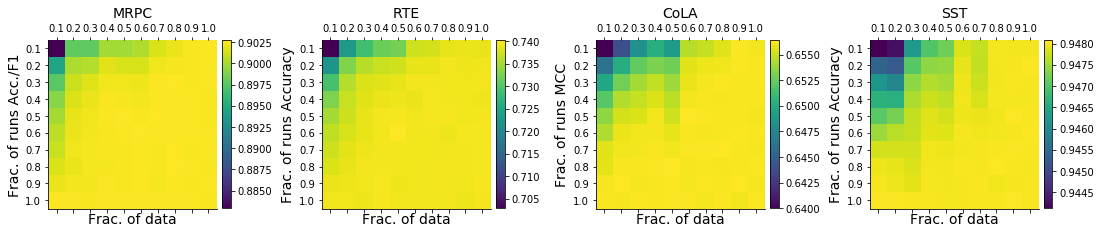

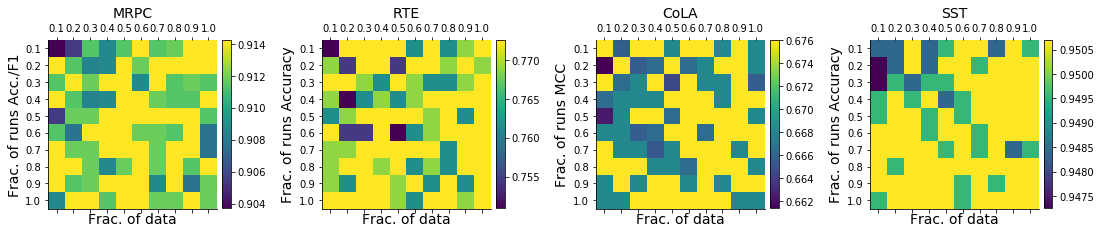

In [333]:
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
plt.subplots_adjust(wspace=0.5)
mins_and_maxes = {}
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    ax.set_title(names[task], fontsize=fontsize, pad=14)
    ax.set_ylabel('Frac. of runs ' + perf_pretty[task], fontsize=fontsize)
    ax.set_xlabel("Frac. of data", fontsize=fontsize)
    m = np.zeros((10,10))
    for r in range(10):
        for d in range(10):
            m[r][d] = es_data[task][((r+1.)/10, (d+1.)/10)]
    im = ax.matshow(m)
    ax.set_xticks([i for i in range(10)])
    ax.set_yticks([i for i in range(10)])
    ax.set_xticklabels(['%.1f' % ((i+1.)/10) for i in range(10)])
    ax.set_ylim(9.5, -0.5)
    ax.set_yticklabels(['%.1f' % ((i+1.)/10) for i in range(10)])
    cbar = plt.colorbar(im,fraction=0.046, pad=0.03, ax=ax)
    mins_and_maxes[task] = (np.min(m), np.max(m))
    
#with the same budget, what's the *gain* in performance from the algorithm above.
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
plt.subplots_adjust(wspace=0.5)
for idx, (task, ax) in enumerate(zip(tasks, axs)):
    num_exps = len(init_seeds[task]) * len(data_seeds[task])
    ax.set_title(names[task], fontsize=fontsize, pad=14)
    ax.set_ylabel('Frac. of runs ' + perf_pretty[task], fontsize=fontsize)
    ax.set_xlabel("Frac. of data", fontsize=fontsize)
    m = np.zeros((10,10))
    for r in range(10):
        for d in range(10):
            r2 = (r+1.)/10; d2 = (d+1.)/10
            budget = int(num_exps * (r2 + d2*(1-r2))) # TODO: check this.
            best = -1000
            for _ in range(budget):
                init_seed = random.choice(init_seeds[task])
                data_seed = random.choice(data_seeds[task])
                best = max(best, get_values(task, init_seed, data_seed)[0])
            m[r][d] = best
    im = ax.matshow(m)#, vmin=mins_and_maxes[task][0], vmax=mins_and_maxes[task][1])
    ax.set_xticks([i for i in range(10)])
    ax.set_yticks([i for i in range(10)])
    ax.set_xticklabels(['%.1f' % ((i+1.)/10) for i in range(10)])
    ax.set_ylim(9.5, -0.5)
    ax.set_yticklabels(['%.1f' % ((i+1.)/10) for i in range(10)])
    cbar = plt.colorbar(im,fraction=0.046, pad=0.03, ax=ax)

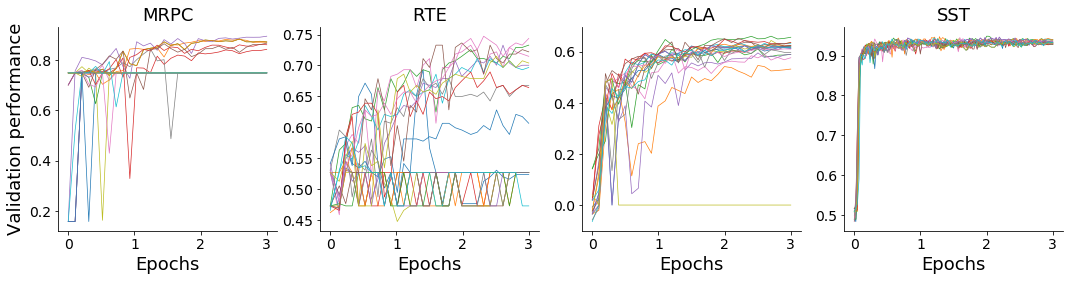

In [72]:
f, axs = plt.subplots(1, len(tasks), figsize=(12*1.5, 2.5*1.5))
fontsize=18
for idx,(task, ax) in enumerate(zip(tasks, axs)):
    ax.set_title(names[task], fontsize=fontsize)
    if idx == 0: ax.set_ylabel('Validation performance', fontsize=fontsize)
    ax.set_xlabel("Epochs",fontsize=fontsize)
    
    sorted_seeds = sorted(performances[task][1].keys(), key=lambda x: performances[task][1][x])
    for k in range(20):
        init_seed, data_seed = random.choice(sorted_seeds)
        d = data[task][init_seed][data_seed][perf[task]]['during']
        xs = [e[0] for e in d if e[0] in batch_nums[task]]
        ys = [e[1] for e in d if e[0] in batch_nums[task]]
        mx_xs = max(xs)
        xs = [3*x/mx_xs for x in xs]
        ax.plot(xs, ys, linewidth=.7)#, label=('WI: %d, DO: %d' % (init_seed, data_seed)))
        ax.tick_params(labelsize=14)
        
#     plt.legend()    
filename = '/home/ilharco/Desktop/data/training_curves'
plt.savefig(filename + '.pdf', bbox_inches='tight', format='pdf')

In [96]:
training_curves_norm, training_curves_max = {}, {}
for task in tasks:
    training_curves_norm[task], training_curves_max[task] = {}, {}
    for init_seed in init_seeds[task]:
        for data_seed in data_seeds[task]:
            d = data[task][init_seed][data_seed][perf[task]]['during']
            training_curves_norm[task][(init_seed, data_seed)] = {'x': [d[0][0]], 'y': [d[0][1]]}
            training_curves_max[task][(init_seed, data_seed)] = {'x': [d[0][0]], 'y': [d[0][1]]}
            for idx in range(1, len(d)):
                training_curves_norm[task][(init_seed, data_seed)]['x'].append(d[idx][0])
                training_curves_norm[task][(init_seed, data_seed)]['y'].append(d[idx][1])
                training_curves_max[task][(init_seed, data_seed)]['x'].append(d[idx][0])
                training_curves_max[task][(init_seed, data_seed)]['y'].append(
                    max(d[idx][1], training_curves_max[task][(init_seed, data_seed)]['y'][-1]))

<Figure size 432x288 with 0 Axes>

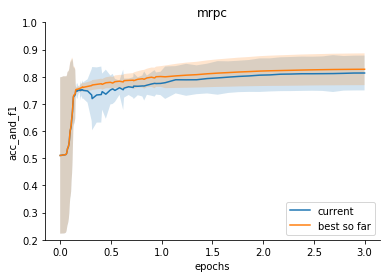

<Figure size 432x288 with 0 Axes>

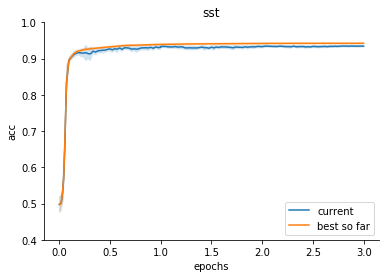

<Figure size 432x288 with 0 Axes>

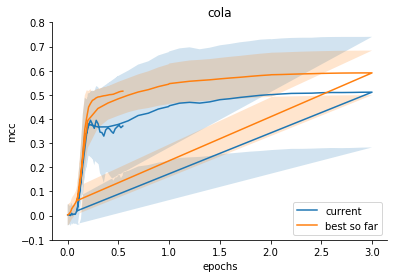

<Figure size 432x288 with 0 Axes>

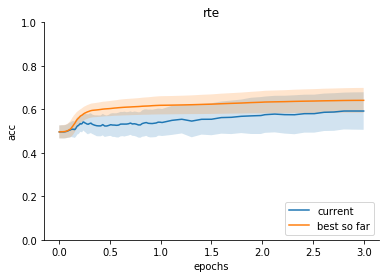

In [97]:
for task in tasks:
    plt.figure()
    fig, ax = plt.subplots(1)
        
    for best_so_far in [False, True]:
        curves_dict = training_curves_max if best_so_far else training_curves_norm
        curves = curves_dict[task]
        vals = collections.defaultdict(list)
        for d in curves.values():
            for x, y in zip(d['x'], d['y']):
                vals[x].append(y)

        xs, ys, lower, higher = [], [], [], []
        max_x = max(vals.keys())
        for x, y in vals.items():
            xs.append(3*x/max_x)
            mean = np.mean(y)
            ys.append(mean)
            std = np.std(y)
            lower.append(mean-std)
            higher.append(mean+std)
        ax.plot(xs, ys)
        ax.fill_between(xs, lower, higher, alpha=0.2)
        ax.set_title(task)
        ax.set_ylabel(perf[task])
        ax.set_xlabel('epochs')
        ax.set_ylim(ylims[task])
    ax.legend(['current', 'best so far'], loc='lower right')
    filename = '/home/ilharco/Desktop/data/aggregate_' + task
    plt.savefig(filename + '.png', bbox_inches='tight')
    

In [30]:
def prepare_data(task, use_init, use_data, final=False):
    assert use_init or use_data
    p = finals[task] if final else bests[task]
    inputs, labels = [], []
    for (init_seed, data_seed), val in p.items():
        inp = []
        if use_init: inp += list(get_onehot_init(init_seed))
        if use_data: inp += list(get_onehot_data(data_seed))
        inputs.append(inp)
        labels.append(val)
    return inputs, labels

In [66]:
task = 'sst'

inputs, labels = prepare_data(task, True, True, final=False)
reg0 = sm.OLS(labels, inputs).fit()
inputs, labels = prepare_data(task, use_init=True, use_data=False, final=False)
reg1 = sm.OLS(labels, inputs).fit()


statsmodels.stats.anova.anova_lm(reg1, reg0)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,90.0,0.000648,0.0,NaN,NaN,NaN
1,81.0,0.000459,9.0,0.000189,3.708399,0.000621


In [69]:
reg1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9550
Date:                Sun, 10 Nov 2019   Prob (F-statistic):              0.482
Time:                        17:16:54   Log-Likelihood:                 455.41
No. Observations:                 100   AIC:                            -890.8
Df Residuals:                      90   BIC:                            -864.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9423      0.001   1110.113      0.000       0.941       0.944
x2             0.9428      0.001   1110.653      0.000       0.941       0.944
x3             0.9423      0.001   1110.113      0.000       0.941       0.944
x4             0.9440      0.001   1112.139      0.000       0.942       0.946
x5             0.9430      0.001   1110.923      0.000       0.941       0.945
x6             0.9432      0.001   1111.193      0.000       0.942       0.945
x7             0.9425      0.001   1110.383      0.000       0.941       0.944
x8             0.9422      0.001   1109.978      0.000       0.941       0.944
x9             0.9408      0.001   1108.356      0.000       0.939       0.943
x10            0.9423      0.001   1110.113      0.000       0.941       0.944
==============================================================================
Omnibus:                        9.860   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.774
Skew:                           0.702   Prob(JB):                      0.00755
Kurtosis:                       3.610   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
a = sm.OLS(labels, inputs).fit()

In [50]:
a.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.035   
Dependent Variable: y                AIC:                -237.3697
Date:               2019-11-10 16:56 BIC:                -211.3180
No. Observations:   100              Log-Likelihood:     128.68   
Df Model:           9                F-statistic:        0.6238   
Df Residuals:       90               Prob (F-statistic): 0.774    
R-squared:          0.059            Scale:              0.0049607
---------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
x1        0.5714      0.0223    25.6540    0.0000    0.5271    0.6156
x2        0.6080      0.0223    27.3002    0.0000    0.5638    0.6523
x3        0.6097      0.0223    27.3754    0.0000    0.5655    0.6540
x4        0.6002      0.0223    26.9472    0.0000    0.5559    0.6444
x5        0.5774      0.0223    25.9246    0.0000    0.5332    0.6217
x6        0.6060      0.0223    27.2091    0.0000    0.5618    0.6503
x7        0.5835      0.0223    26.1999    0.0000    0.5393    0.6278
x8        0.6097      0.0223    27.3766    0.0000    0.5655    0.6540
x9        0.5647      0.0223    25.3542    0.0000    0.5205    0.6090
x10       0.6065      0.0223    27.2309    0.0000    0.5623    0.6508
------------------------------------------------------------------
Omnibus:               29.302       Durbin-Watson:          2.174 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       42.416
Skew:                  -1.444       Prob(JB):               0.000 
Kurtosis:              4.354        Condition No.:          1     
==================================================================

"""

<IPython.core.display.Javascript object>


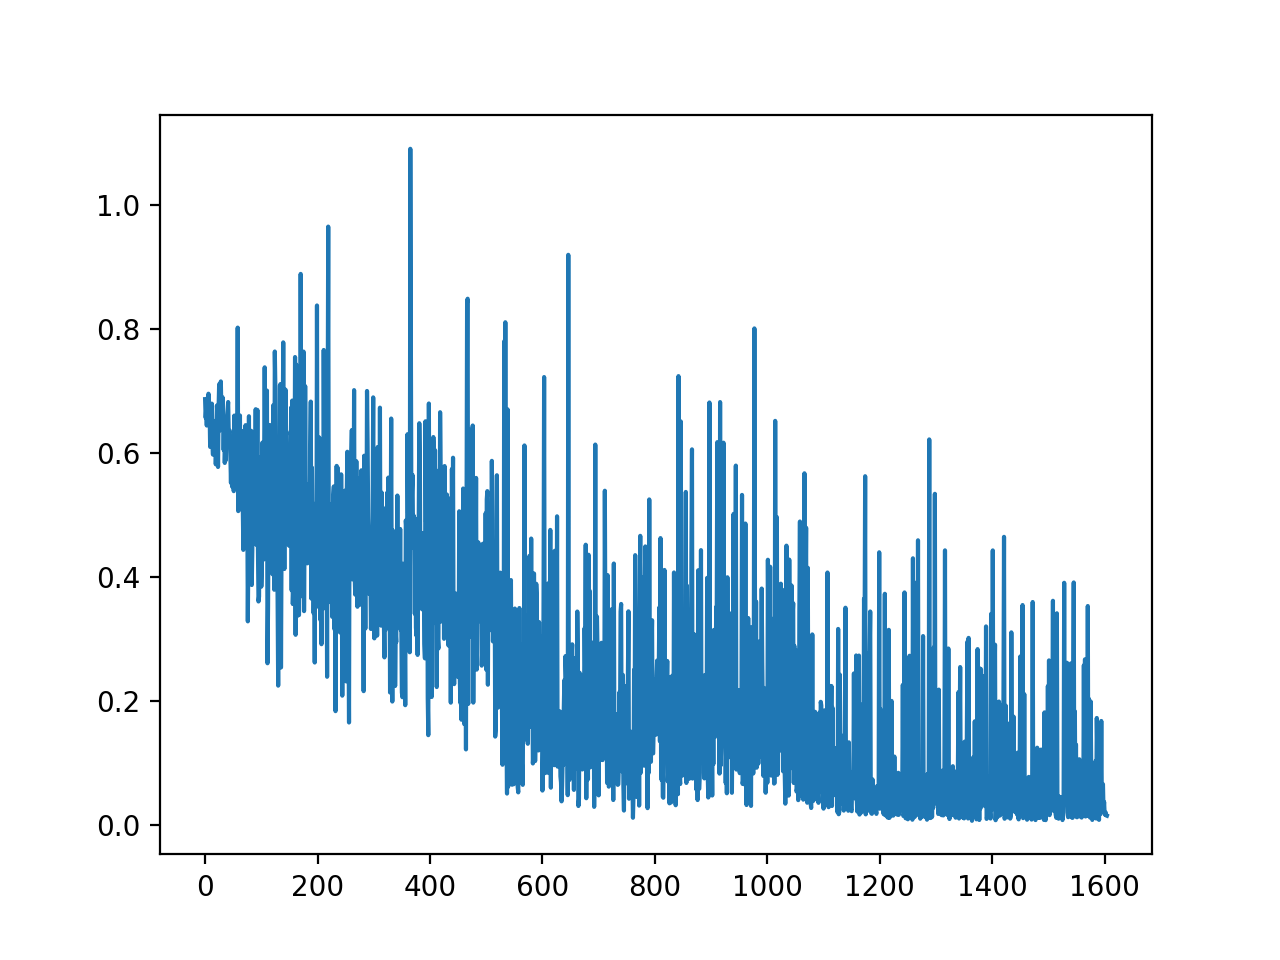

In [36]:
plt.figure()
d = np.array(data['cola'][1][4]['train_loss']['during'])
plt.plot(d)

In [12]:
bests, finals = {}, {}
for task in data.keys():
    bests[task], finals[task] = {}, {}
    for init_seed in data[task].keys():
        for data_seed in data[task][init_seed].keys():
            d = np.array(data[task][init_seed][data_seed][perf[task]]['during'])[:, 1]
            bests[task][(init_seed, data_seed)] = max(d)
            finals[task][(init_seed, data_seed)] = d[-1]
    print('TASK:', task)
    b = list(bests[task].values())
    f = list(finals[task].values())
    print('  best:  %.2f %.2f' % (100*np.max(b), 100*np.std(b)))
    print('  final: %.2f %.2f' % (100*np.max(f), 100*np.std(f)))

TASK: mrpc
  best:  90.87 5.29
  final: 90.36 6.27
TASK: sst
  best:  95.07 0.27
  final: 94.50 0.41
TASK: cola
  best:  66.57 6.89
  final: 64.50 25.06


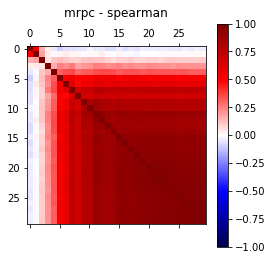

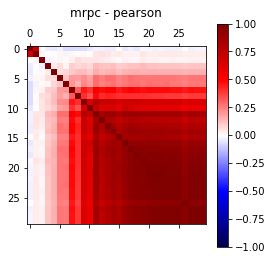

In [67]:
task = 'sst'
batches = np.array(data[task][1][1][perf[task]]['during'], dtype=np.int)[:, 0]
interval = batches[-1] - batches[-2]

In [71]:
b = [batches[idx] for idx in range(len(batches)-1) if batches[idx+1] - batches[idx] == interval]
b = [0] * (b[0] // interval) + b

In [72]:
np.array(b, dtype=np.int)

array([    0,     0,     0,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4210,  4310,  4410,
        4510,  4610,  4710,  4810,  4910,  5010,  5110,  5210,  5310,
        5410,  5510,  5610,  5710,  5810,  5910,  6010,  6110,  6210,
        6310,  6410,  6510,  6610,  6710,  6810,  6910,  7010,  7110,
        7210,  7310,  7410,  7510,  7610,  7710,  7810,  7910,  8010,
        8110,  8210,  8310,  8420,  8520,  8620,  8720,  8820,  8920,
        9020,  9120,  9220,  9320,  9420,  9520,  9620,  9720,  9820,
        9920, 10020, 10120, 10220, 10320, 10420, 10520, 10620, 10720,
       10820, 10920, 11020, 11120, 11220, 11320, 11420, 11520, 11620,
       11720, 11820, 11920, 12020, 12120, 12220, 12320, 12420, 12520])

In [52]:
batches = list(batches)
np.array(batches, dtype=np.int)

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    60,    70,    80,
          90,   100,   110,   120,   130,   140,   150,   160,   170,
         180,   190,   200,   210,   220,   230,   240,   250,   260,
         270,   280,   290,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4210,  4310,
        4410,  4510,  4610,  4710,  4810,  4910,  5010,  5110,  5210,
        5310,  5410,

In [53]:
np.shape(m)

(201, 201)

In [54]:
for m_i in range(len(m)):
    for i, b in enumerate(batches):
        

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4210,
 4310,
 4410,
 4510,
 4610,
 4710,
 4810,
 4910,
 5010,
 5110,
 5210,
 5310,
 5410,
 5510,
 5610,
 5710,
 5810,
 5910,
 6010,
 6110,
 6210,
 6310,
 6410,
 6510,
 6610,
 6710,
 6810,
 6910,
 7010,
 7110,
 7210,
 7310,
 7410,
 7510,
 7610,
 7710,
 7810,
 7910,
 8010,
 8110,
 8210,
 8310,
 8410,
 8420,
 8520,
 8620,
 8720,
 8820,
 8920,

In [47]:
mode = 'spearman'
batches = np.array(data[task][1][1][perf[task]]['during'])[:, 0]

data_per_batch = collections.defaultdict(list)

for init_seed in data[task].keys():
    for data_seed in data[task][init_seed].keys():
        for [b, v] in data[task][init_seed][data_seed][perf[task]]['during']:
            data_per_batch[b].append(v)

matrix = {}
for b1 in batches:
    matrix[b1] = {}
    b1_vals = data_per_batch[b1]
    for b2 in batches:
        b2_vals = data_per_batch[b2]
        fn = scipy.stats.spearmanr if mode == 'spearman' else scipy.stats.pearsonr
        matrix[b1][b2] = fn(b1_vals, b2_vals)

m = np.zeros((len(batches), len(batches)))
for i1, b1 in enumerate(batches):
    for i2, b2 in enumerate(batches):
        m[i1][i2] = matrix[b1][b2][0]

<IPython.core.display.Javascript object>


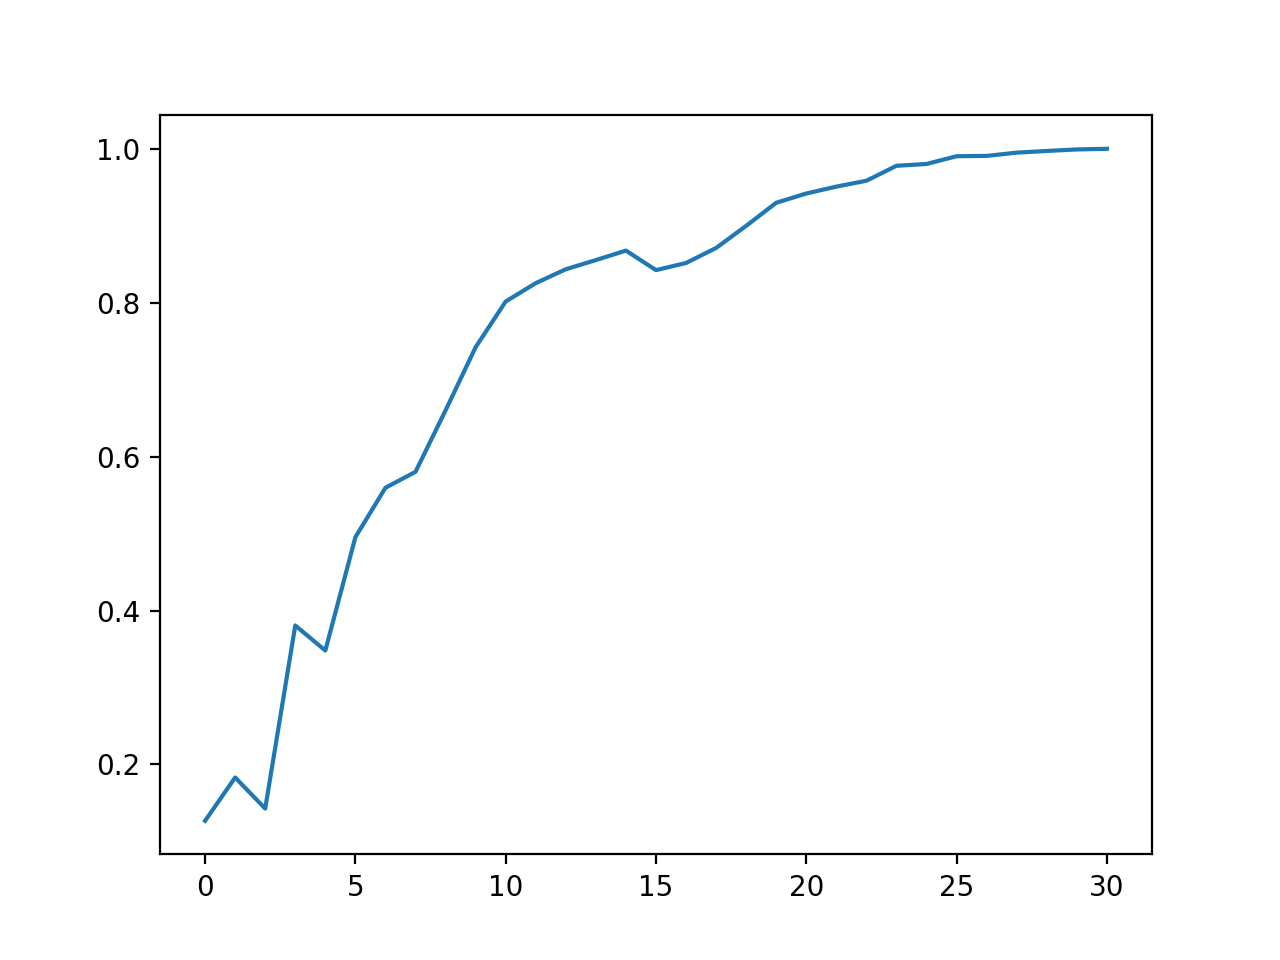

In [48]:
plt.figure()
plt.plot(norm_vals)
plt.show()